# Preprocessing

In [317]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [318]:
%autoreload 2

In [319]:
import torch

In [320]:
from src.vfm.connection import Connection
from src.vfm.preprocessor import Preprocessor
from src.vfm.resampler import Resampler
from src.vfm.utils.descriptive_utils import *
from src.vfm.model.physics.physics_informed import PhysicsInformedHybridModel
import json

In [321]:
connection = Connection()
# Get client
client = connection.get_client()

In [322]:
df_all_wells = connection.get_data(client, wells=get_all_wells())
df_all_wells.columns

Index(['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'qo_well_test',
       'qg_well_test', 'qw_well_test', 'qo_mpfm', 'qg_mpfm', 'wc_mpfm',
       'well_id'],
      dtype='object')

In [323]:
dependent_vars=get_depdendent_vars()
independent_vars=get_independent_vars()

In [324]:
preprocessor = Preprocessor()
df_all_wells_preprocessed = preprocessor.preprocess_wells(df=df_all_wells)
len(df_all_wells_preprocessed)

Total original record count 834
W06 original record count: 137
W06 Record count before target preprocessing: 100
W06 Record count after target preprocessing: 98
W06 Record count after preprocessing: 98
W08 original record count: 69
W08 Record count before target preprocessing: 66
W08 Record count after target preprocessing: 53
W08 Record count after preprocessing: 53
W10 original record count: 222
W10 Record count before target preprocessing: 221
W10 Record count after target preprocessing: 212
W10 Record count after preprocessing: 212
W11 original record count: 154
W11 Record count before target preprocessing: 119
W11 Record count after target preprocessing: 116
W11 Record count after preprocessing: 116
W15 original record count: 86
W15 Record count before target preprocessing: 86
W15 Record count after target preprocessing: 80
W15 Record count after preprocessing: 80
W18 original record count: 89
W18 Record count before target preprocessing: 86
W18 Record count after target preproces

718

In [325]:
summarize_null(df_all_wells_preprocessed)

qo_well_test      0
qg_well_test      0
qw_well_test      0
well_code         0
dhp               0
dht               0
whp               0
wht               0
choke             0
dcp               0
qo_mpfm          30
qg_mpfm          30
qw_mpfm          30
wc_mpfm           0
gor_mpfm         34
wgr_mpfm         35
gor_well_test     0
wgr_well_test     0
well_id           0
time_idx          0
dtype: int64

In [354]:
df_train, df_val, df_test = get_blocked_temporal_train_val_test_split(df=df_all_wells_preprocessed)
print(f"Train={len(df_train)}, Validation={len(df_val)}, Test={len(df_test)}")

Train=527, Validation=58, Test=133


In [355]:
well_geometry: dict = None

with open(r"data\well_geometry.json", "r") as f:
    well_geometry = json.load(f)



In [356]:
model = PhysicsInformedHybridModel(dependant_vars=dependent_vars, independent_vars=independent_vars, well_geometry=well_geometry,)
model.fit(df=df_train, df_val=df_val)

[Validation] Residual RMSE = 0.6368


In [357]:
df_train["qw_well_test"].describe()

count    527.000000
mean       4.998384
std       11.985397
min        0.000034
25%        0.487474
50%        2.471934
75%        4.334326
max      152.615160
Name: qw_well_test, dtype: float64

In [360]:
model.score_physics(df_test)

{'W06': {'qo': {'r2': 0.5237917584574934,
   'mae': 17.55667593895778,
   'rmse': 21.6731875372625,
   'mape (%)': 20.434747797611223,
   'mpe (%)': 7.52860771576329},
  'qw': {'r2': 0.01119295546925525,
   'mae': 1.0730414012096143,
   'rmse': 1.4250204236274011,
   'mape (%)': 889.0932836566242,
   'mpe (%)': 854.9865634490111},
  'qg': {'r2': 0.7443312522757455,
   'mae': 1683.1895947050807,
   'rmse': 1985.7477955000627,
   'mape (%)': 12.725812077036034,
   'mpe (%)': -12.050170201599359},
  'wgr': {'r2': -1.9352356080235746,
   'mae': 8.656332853329239e-05,
   'rmse': 0.00014518264514124231,
   'mape (%)': 450.9800671200832,
   'mpe (%)': 424.42200107671067},
  'gor': {'r2': -528.0426238135682,
   'mae': 14.57111108957847,
   'rmse': 29.416170491227195,
   'mape (%)': 11.921136129986065,
   'mpe (%)': -11.5604373265379}},
 'W08': {'qo': {'r2': -0.21165027568604544,
   'mae': 8.188280229219345,
   'rmse': 9.305554789624555,
   'mape (%)': 44.617388493010495,
   'mpe (%)': 11.50816

In [331]:
model.score_hybrid(df_test)

{'W06': {'qo': {'r2': 0.685329622815332,
   'mae': 14.750738111238446,
   'rmse': 17.61782394022264,
   'mape (%)': 11.930375167228993,
   'mpe (%)': -10.326726757192375},
  'qw': {'r2': -1.2853138256913188,
   'mae': 1.6246877368979704,
   'rmse': 2.1663979517349747,
   'mape (%)': 100.0,
   'mpe (%)': -100.0},
  'qg': {'r2': 0.8388026131300959,
   'mae': 1268.8190984181472,
   'rmse': 1576.7551770139428,
   'mape (%)': 10.915176243076724,
   'mpe (%)': -3.4343186919519195},
  'wgr': {'r2': -1.7618103092987507,
   'mae': 0.00011247934911454018,
   'rmse': 0.00014082836729331356,
   'mape (%)': 100.0,
   'mpe (%)': -100.0},
  'gor': {'r2': -509.40841523377634,
   'mae': 20.424285809185005,
   'rmse': 28.893470868686915,
   'mape (%)': 16.608730085635177,
   'mpe (%)': 8.478207278907018}},
 'W08': {'qo': {'r2': -1.164274554909467,
   'mae': 9.27587122232902,
   'rmse': 12.436833052566119,
   'mape (%)': 62.393078134988315,
   'mpe (%)': 48.08964445899072},
  'qw': {'r2': 0.8578709668299

In [332]:
model.score_mpfm(df=df_test)

{'W06': {'qo': {'r2': 0.9773211156315122,
   'mae': 4.096674635957687,
   'rmse': 4.729717249417592,
   'mape (%)': 3.1083449972886226,
   'mpe (%)': 2.9382273793644957},
  'qw': {'r2': -1.104060628383758,
   'mae': 1.5561051535015358,
   'rmse': 2.078712548682462,
   'mape (%)': 92.31770935824498,
   'mpe (%)': -92.31770935824498},
  'qg': {'r2': 0.9456208213607113,
   'mae': 629.9087979851056,
   'rmse': 915.8020023341,
   'mape (%)': 4.265069439396897,
   'mpe (%)': 4.265069439396897},
  'wgr': {'r2': -1.572644216279104,
   'mae': 0.00010766108500146669,
   'rmse': 0.00013591991237688652,
   'mape (%)': 92.03044893571888,
   'mpe (%)': -92.03044893571888},
  'gor': {'r2': -20.334853954053724,
   'mae': 4.013014931491606,
   'rmse': 5.90725392188949,
   'mape (%)': 3.2450022876375066,
   'mpe (%)': 1.310015847868659}},
 'W08': {'qo': {'r2': 0.6358948909643096,
   'mae': 4.15015248331985,
   'rmse': 5.1011373149084696,
   'mape (%)': 26.0646881645185,
   'mpe (%)': 3.639688989142107},

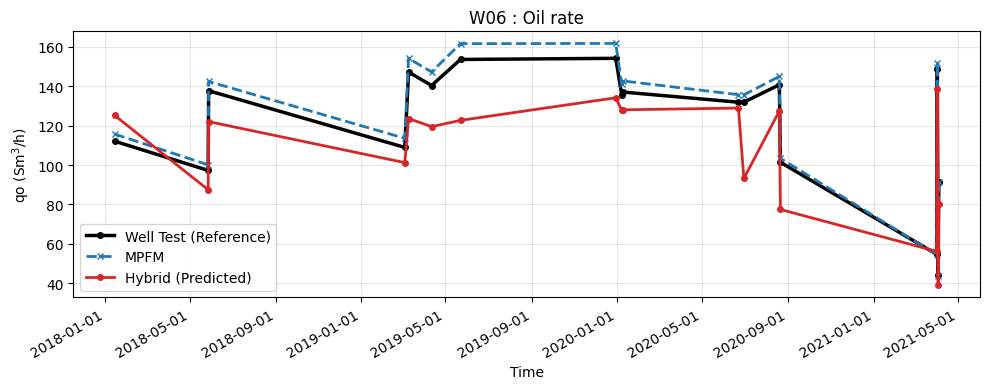

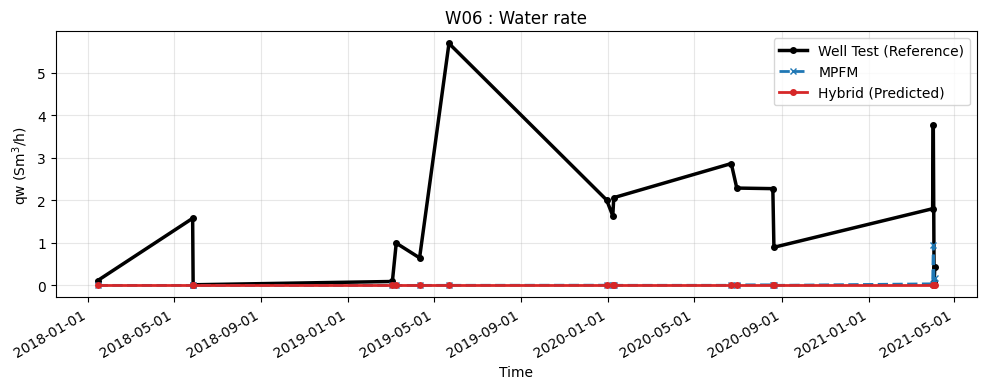

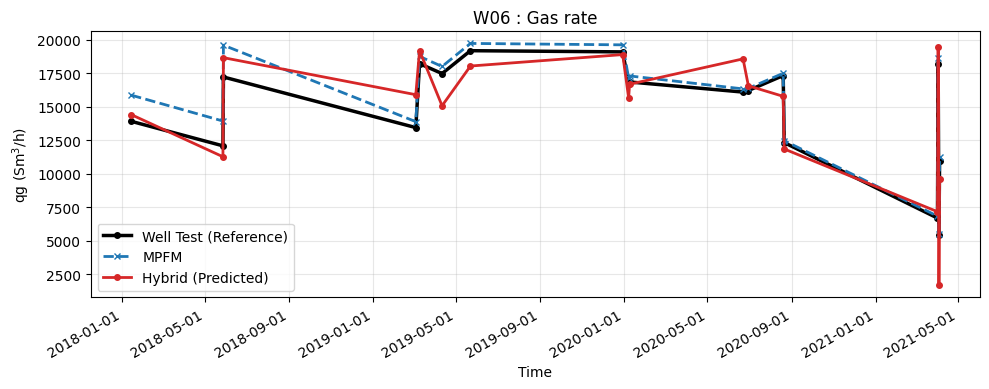

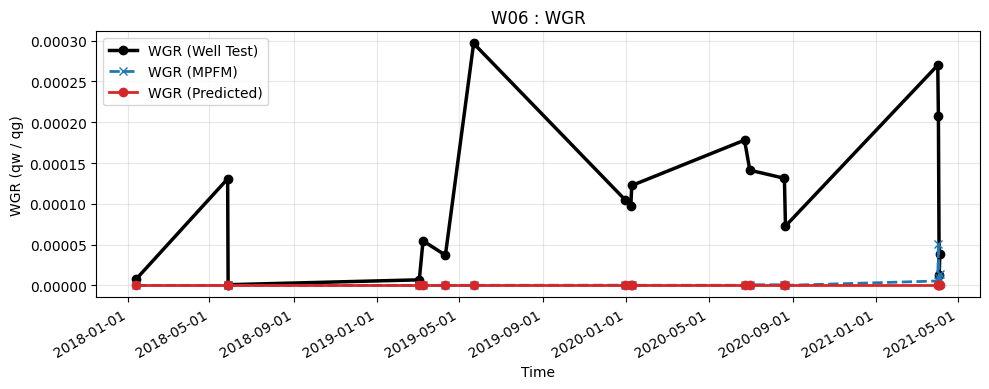

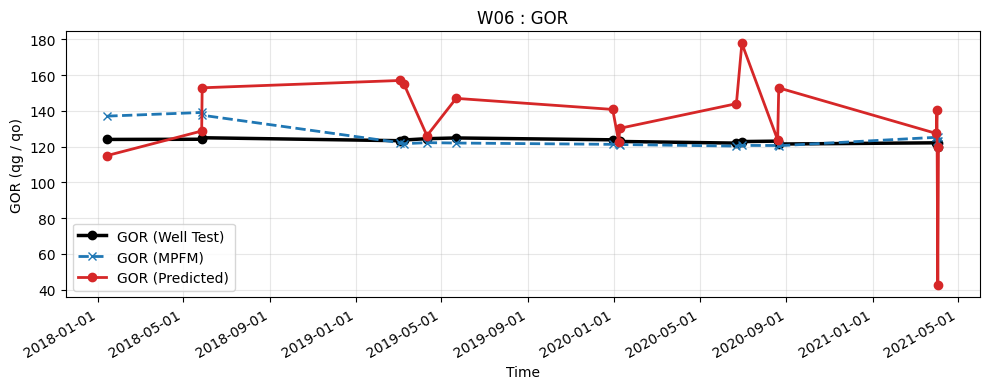

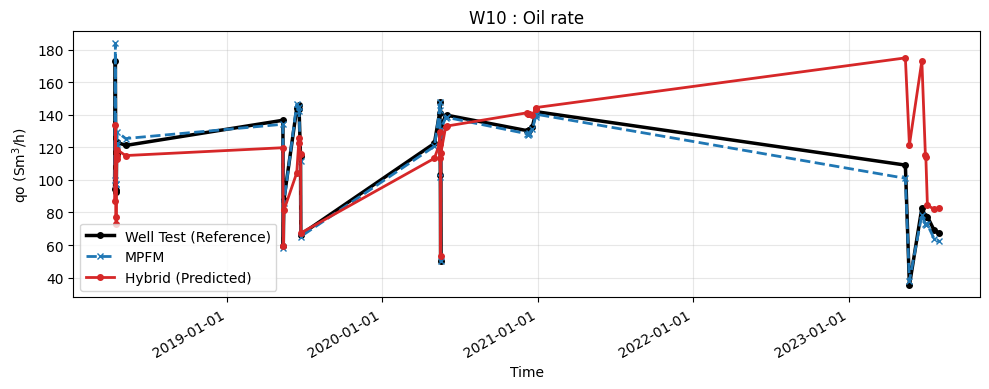

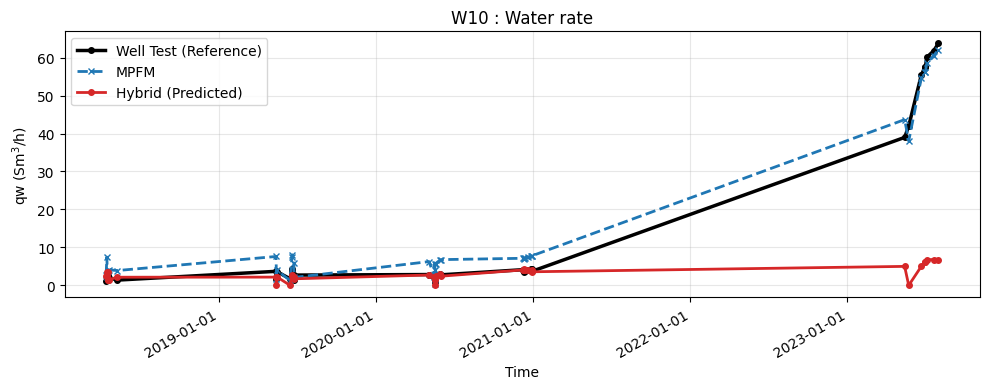

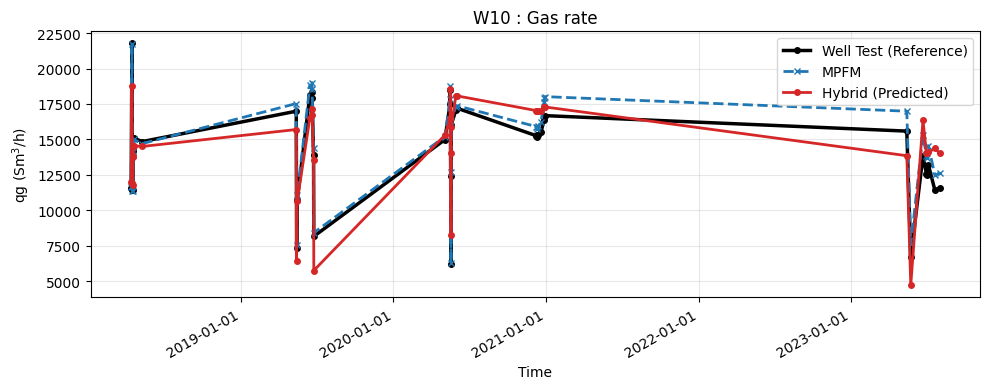

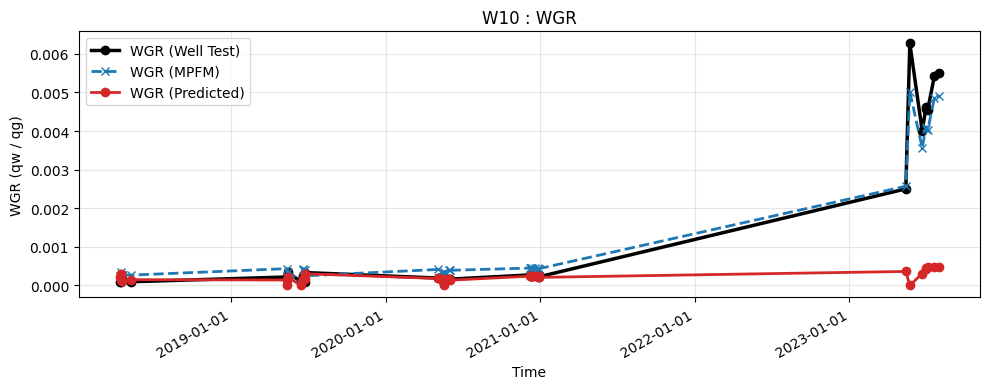

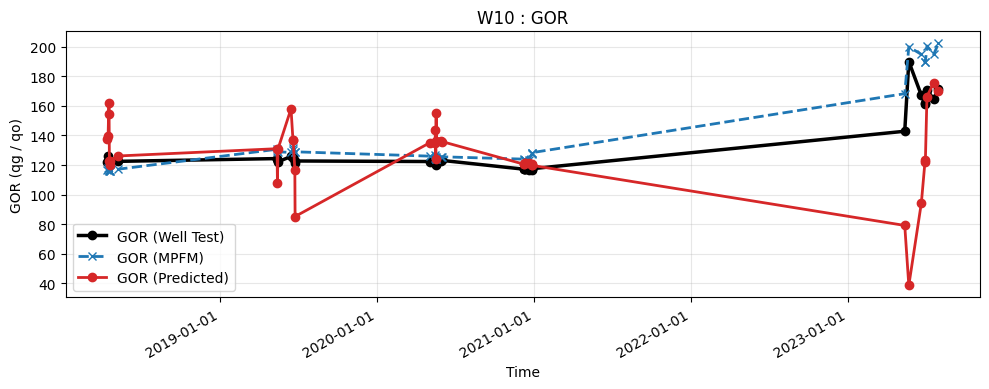

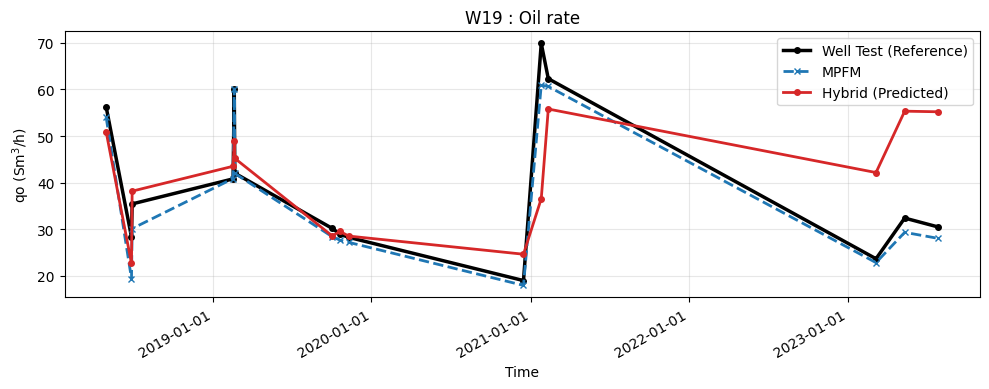

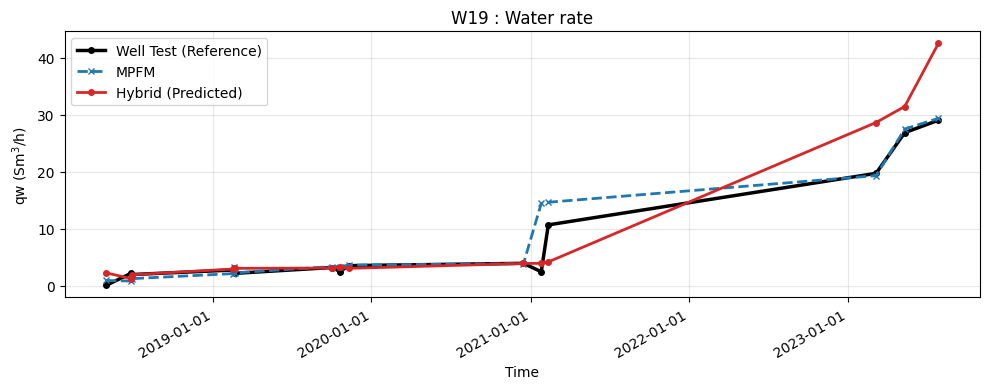

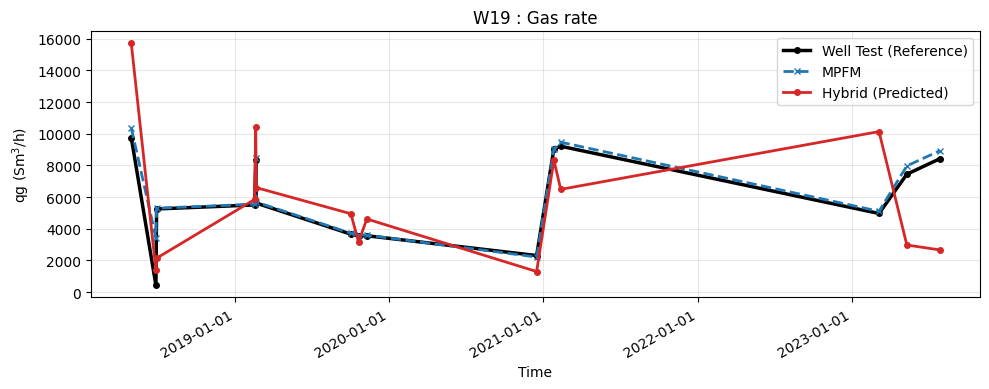

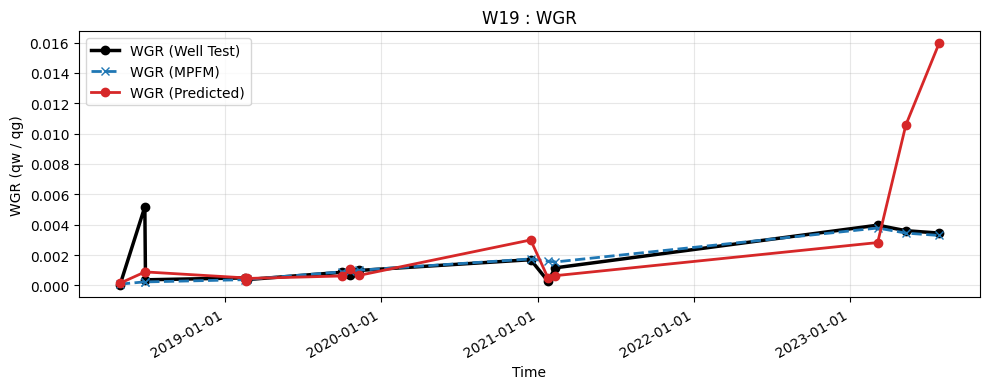

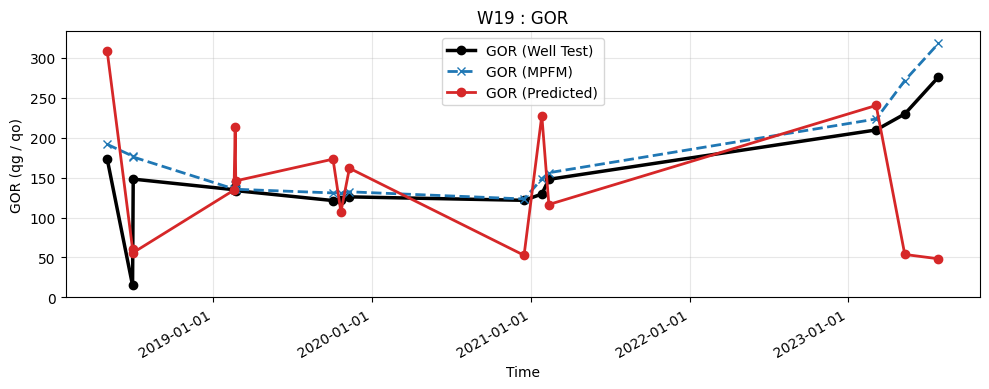

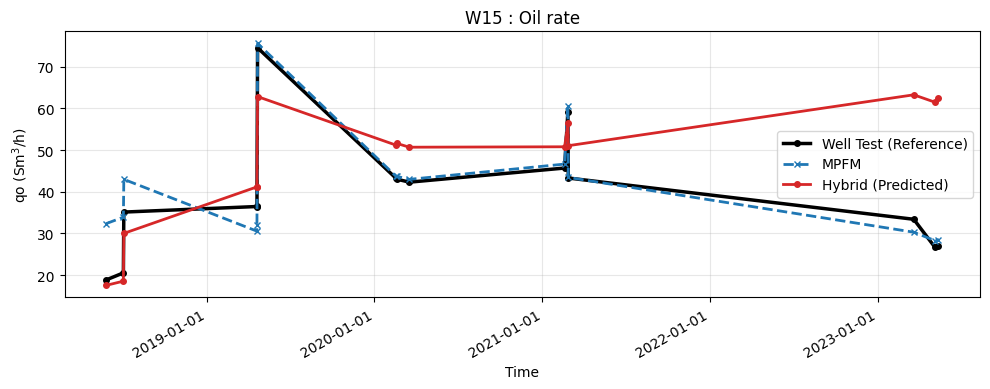

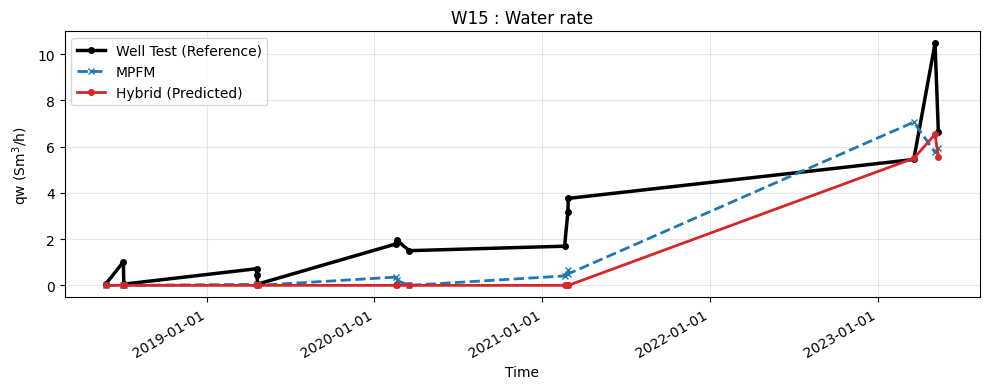

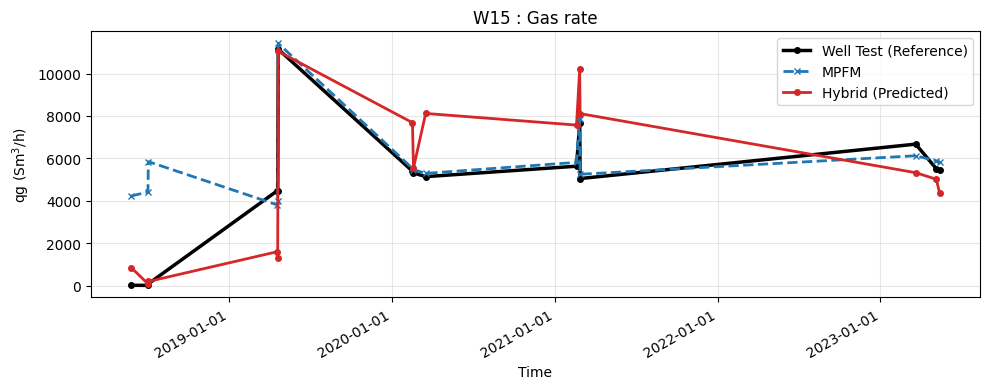

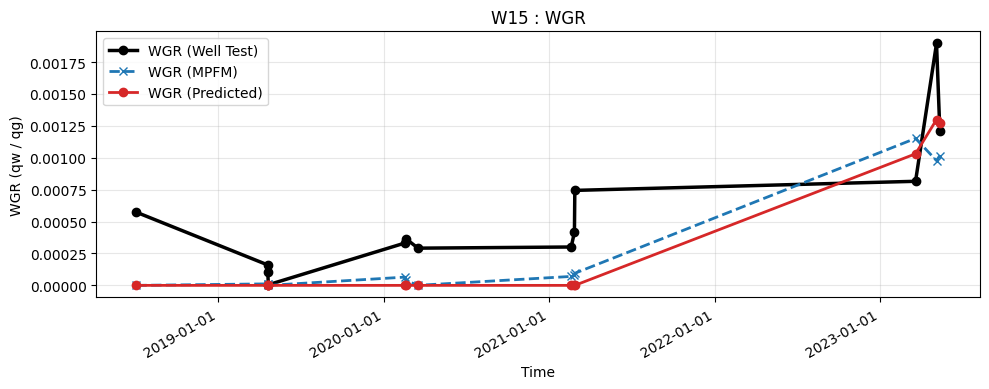

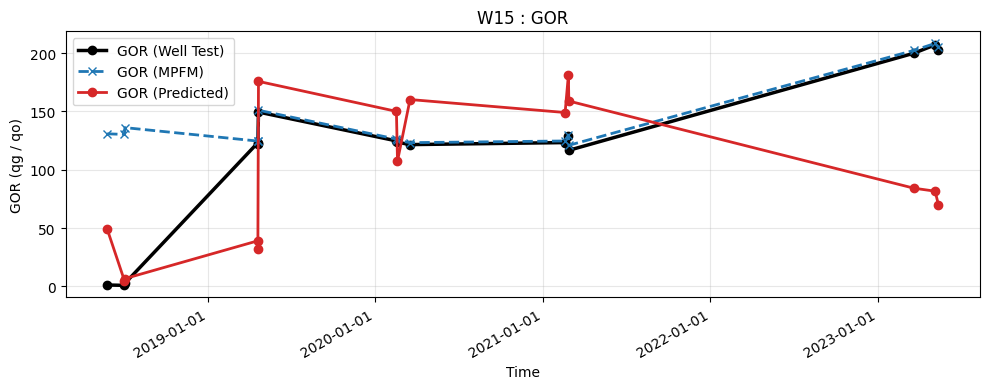

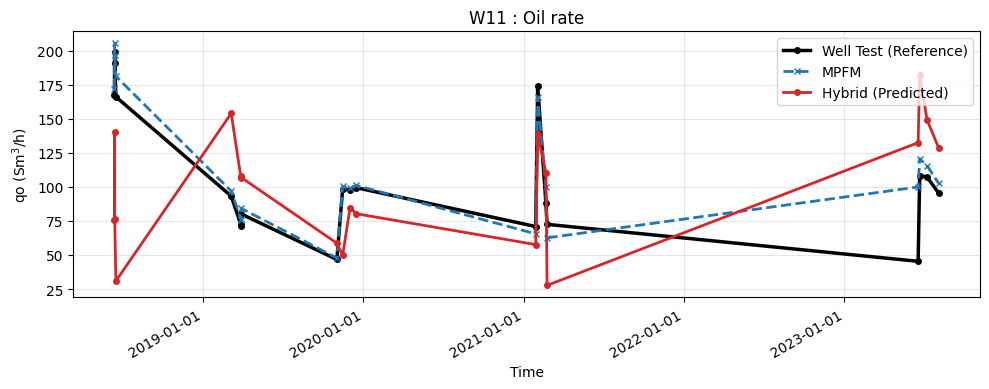

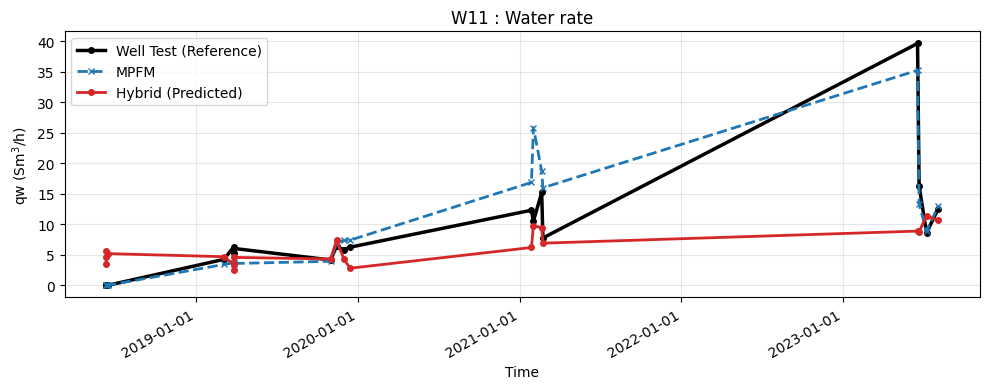

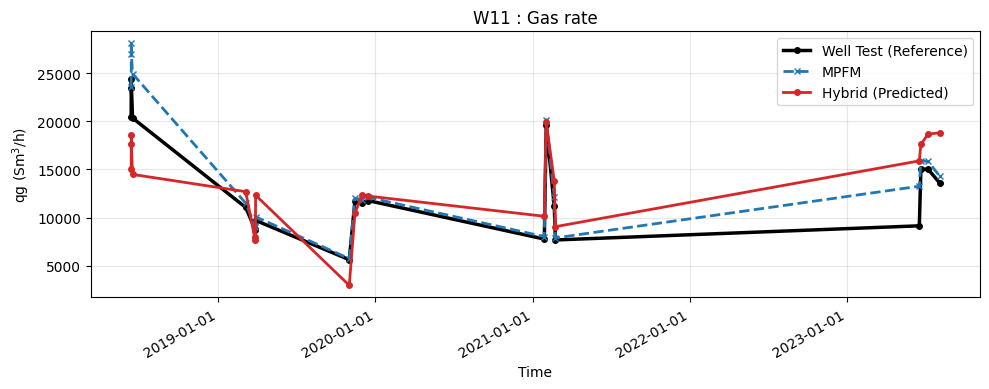

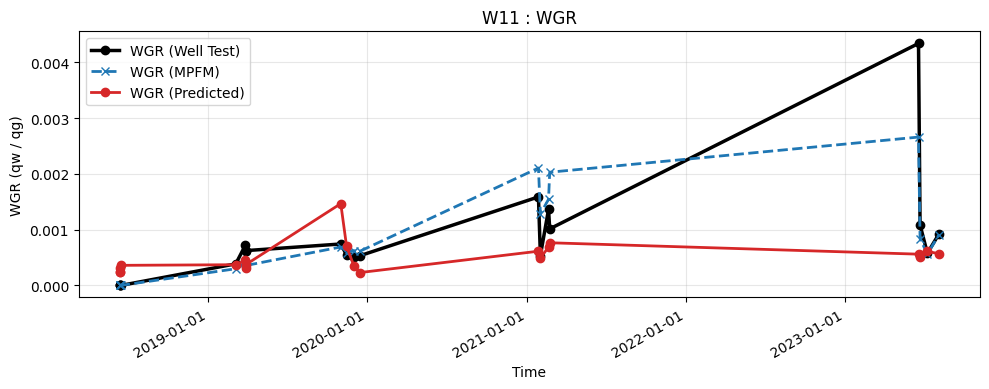

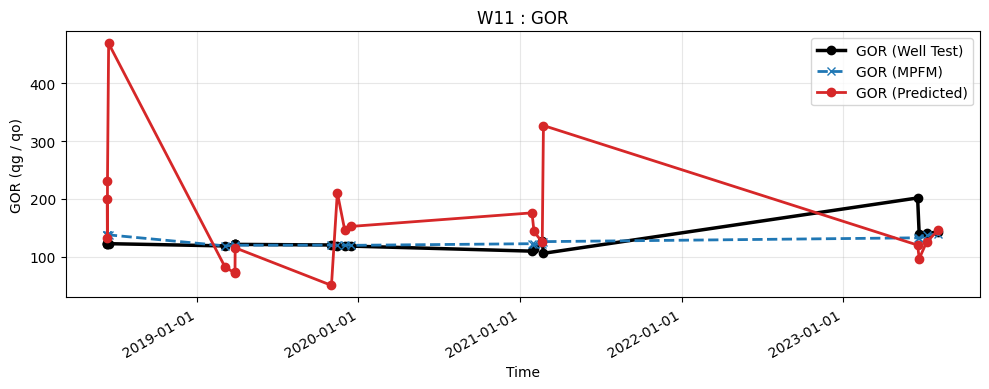

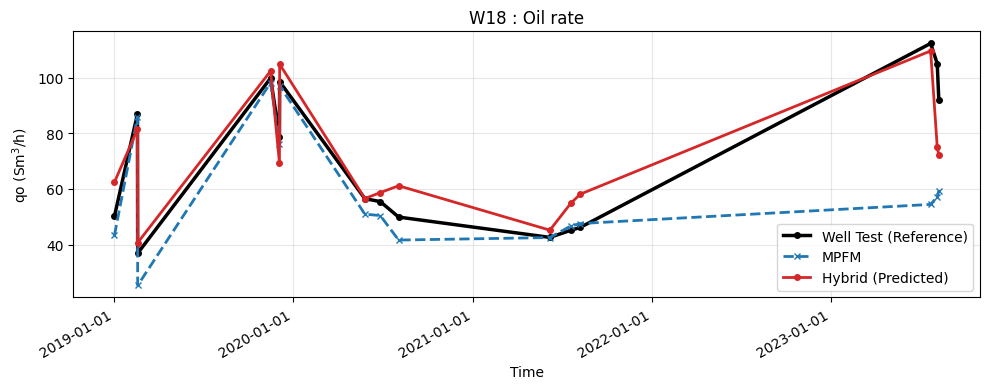

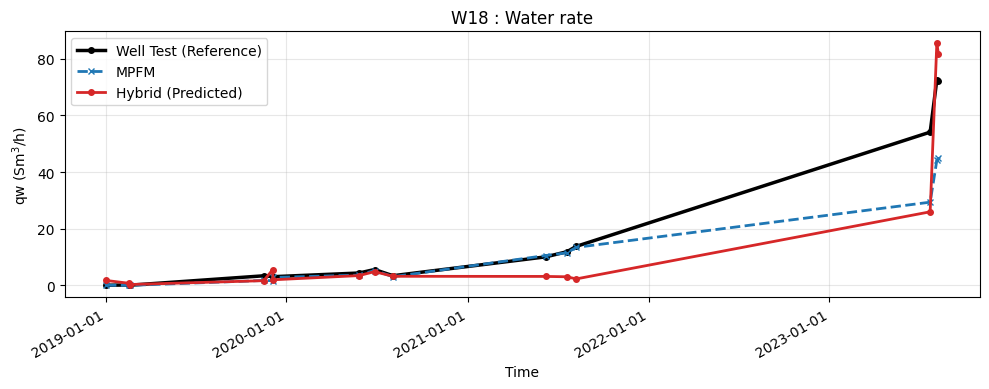

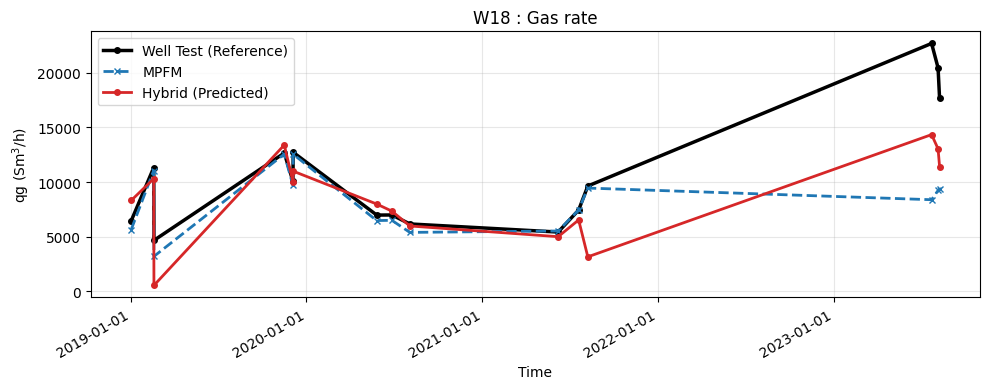

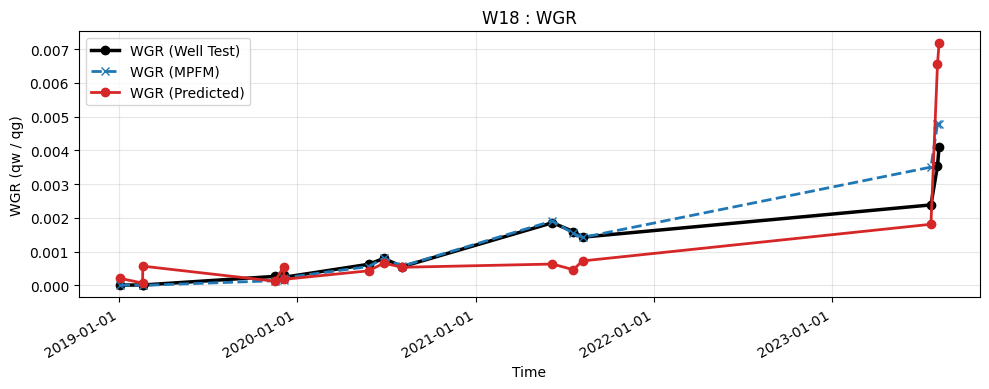

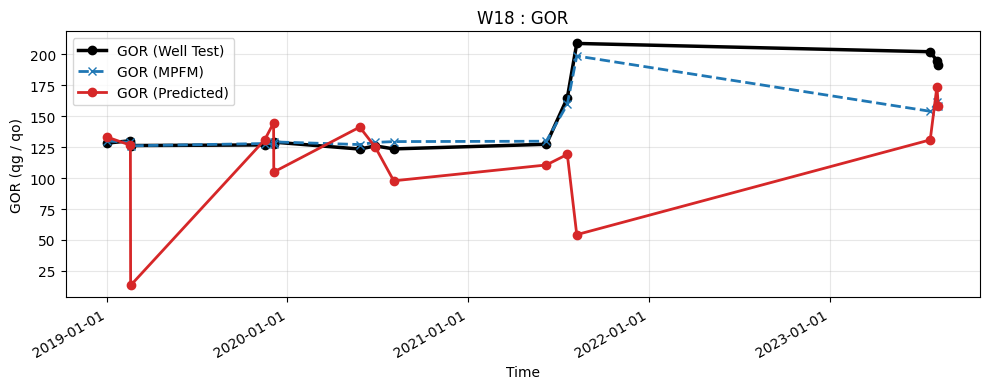

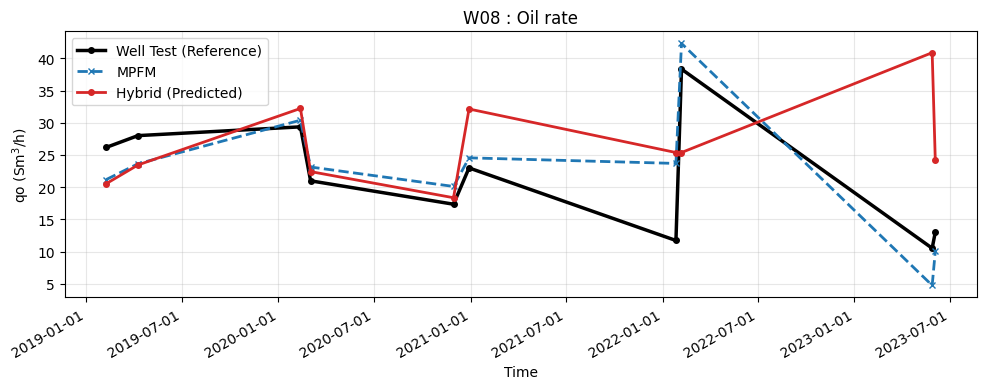

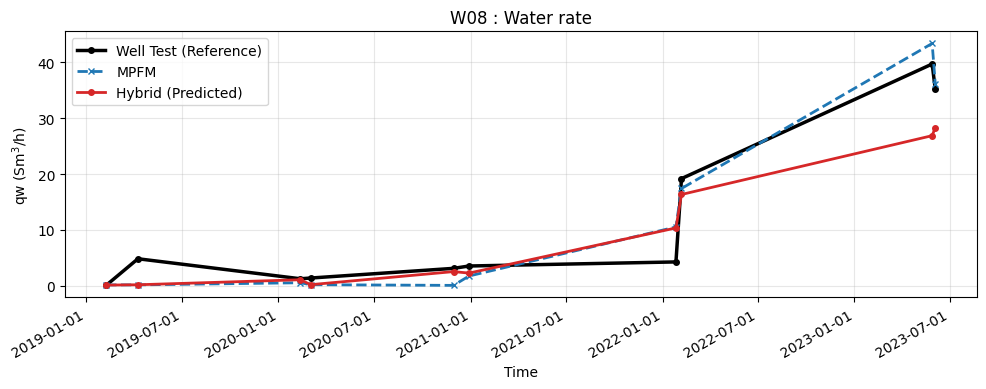

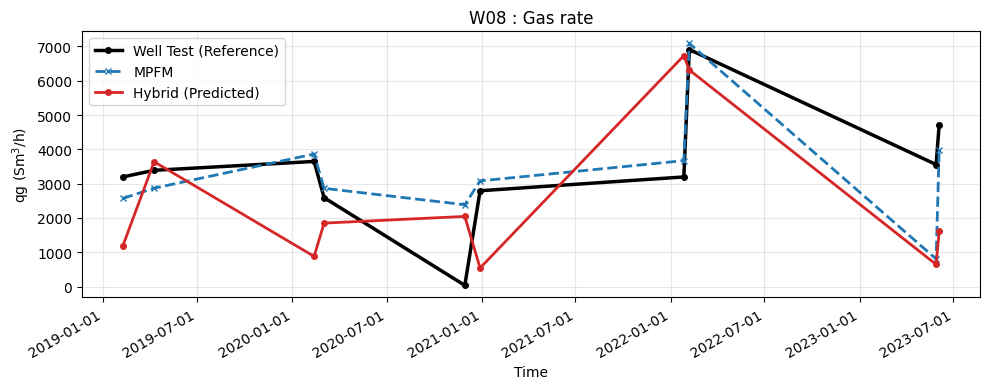

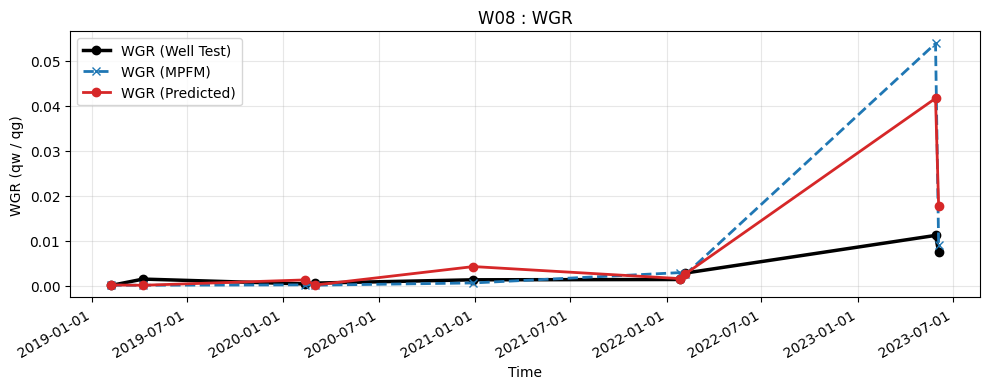

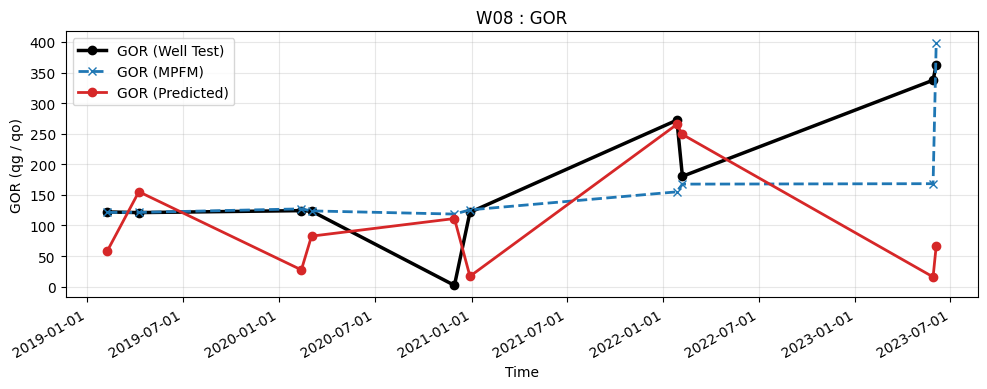

In [333]:
model.plot_predictions(df=df_test, is_hybrid_model=True)

### LOWO test

In [334]:
df_train_lowo, df_val_lowo, df_calibration_lowo, df_test_lowo = get_lowo_train_val_test_split(df=df_all_wells_preprocessed, test_well_id="W10")
print(f"{len(df_train_lowo)}, {len(df_val_lowo)}, {len(df_calibration_lowo)}, {len(df_test_lowo)}")

405, 101, 25, 187


In [335]:
model_lowo = PhysicsInformedHybridModel(dependant_vars=dependent_vars, independent_vars=independent_vars, well_geometry=None)
model_lowo.fit(df=df_train_lowo, df_val=df_val_lowo)

[Validation] Residual RMSE = 0.6722


In [336]:
model_lowo.calibrate_physics_only(df=df_calibration_lowo)

In [337]:
model_lowo.score_physics(df_test_lowo)

{'W10': {'qo': {'r2': 0.1701937005120413,
   'mae': 21.579846683590965,
   'rmse': 29.707528359552366,
   'mape (%)': 27.197937882720698,
   'mpe (%)': 21.547998136223832},
  'qw': {'r2': 0.07053205506789262,
   'mae': 3.15706463975898,
   'rmse': 10.525100592886917,
   'mape (%)': 45793.67245205843,
   'mpe (%)': 45761.931281713914},
  'qg': {'r2': 0.7877567495022543,
   'mae': 1380.8057389455994,
   'rmse': 1912.5796456140074,
   'mape (%)': 305.09505809897644,
   'mpe (%)': 297.7743618772813},
  'wgr': {'r2': -7.174231373552331e-05,
   'mae': 0.0002722526575679322,
   'rmse': 0.0009519231225402966,
   'mape (%)': 108.29411236531004,
   'mpe (%)': 74.0155340122689},
  'gor': {'r2': -1.723417712224323,
   'mae': 16.716524506825575,
   'rmse': 27.161931907196674,
   'mape (%)': 152.54062170002263,
   'mpe (%)': 130.82014116713685}}}

In [338]:
model_lowo.score_hybrid(df_test_lowo)

{'W10': {'qo': {'r2': 0.4226842223304492,
   'mae': 21.10698789612112,
   'rmse': 24.779062436301523,
   'mape (%)': 19.562939134942205,
   'mpe (%)': 11.137673227713362},
  'qw': {'r2': 0.0501401030047296,
   'mae': 3.958172617272861,
   'rmse': 10.639931281342076,
   'mape (%)': 19807.766802426708,
   'mpe (%)': 19689.429264286548},
  'qg': {'r2': 0.28572896169071116,
   'mae': 2836.5730919399994,
   'rmse': 3508.6019947800605,
   'mape (%)': 46.99298436211518,
   'mpe (%)': 36.45540511695777},
  'wgr': {'r2': 4.63264889443149e-05,
   'mae': 0.0003302277139175852,
   'rmse': 0.0009518669287013781,
   'mape (%)': 87.48229625784658,
   'mpe (%)': -39.38084967595455},
  'gor': {'r2': -3.448766112616493,
   'mae': 22.857047395545976,
   'rmse': 34.71549117524215,
   'mape (%)': 40.66872716534349,
   'mpe (%)': 25.027811590543436}}}

In [339]:
model_lowo.score_mpfm(df=df_test_lowo)

{'W10': {'qo': {'r2': 0.9573146565702113,
   'mae': 4.0739903479775235,
   'rmse': 6.785021167242643,
   'mape (%)': 3.436683785551943,
   'mpe (%)': 0.9434008508073018},
  'qw': {'r2': 0.9331646392393113,
   'mae': 2.4216361109795543,
   'rmse': 2.84985470660758,
   'mape (%)': 90318.52908780299,
   'mpe (%)': 90304.60552032806},
  'qg': {'r2': 0.9384748210795809,
   'mae': 518.9530500814592,
   'rmse': 1037.0723321858304,
   'mape (%)': 470.54216191236293,
   'mpe (%)': 469.6691628057131},
  'wgr': {'r2': 0.9498410090729891,
   'mae': 0.00017034384442089718,
   'rmse': 0.00021535920082352625,
   'mape (%)': 141.84953419442144,
   'mpe (%)': 128.62766526914655},
  'gor': {'r2': 0.13800513457837038,
   'mae': 8.185063316478605,
   'rmse': 15.446797304188532,
   'mape (%)': 478.47356905996935,
   'mpe (%)': 474.65886487977815}}}

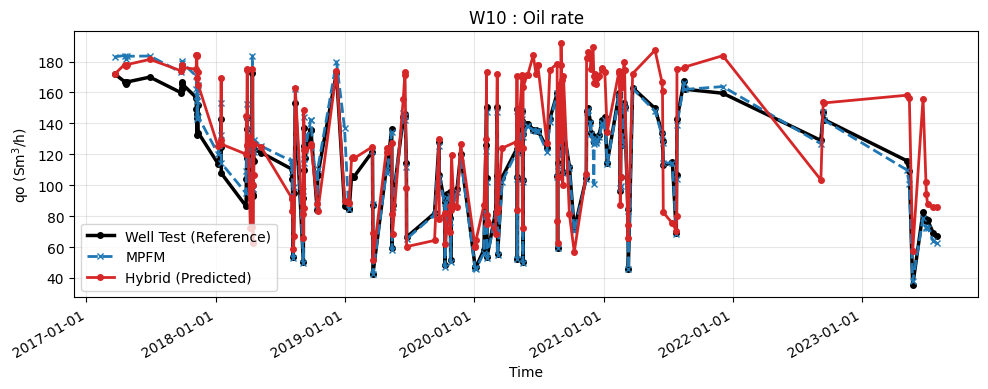

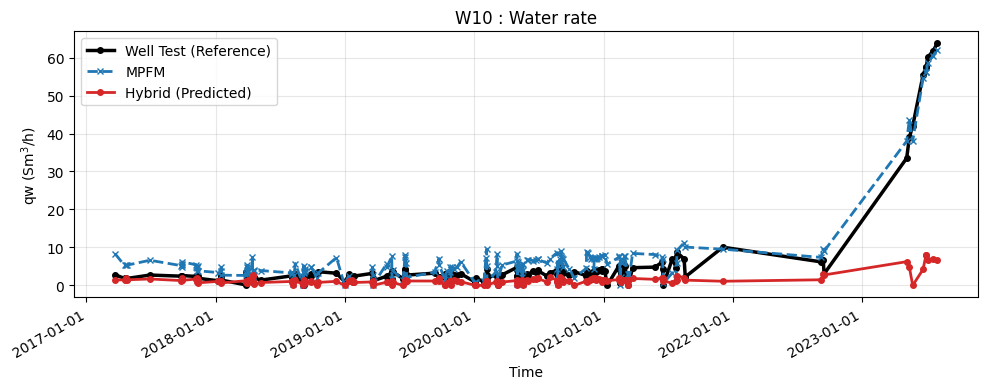

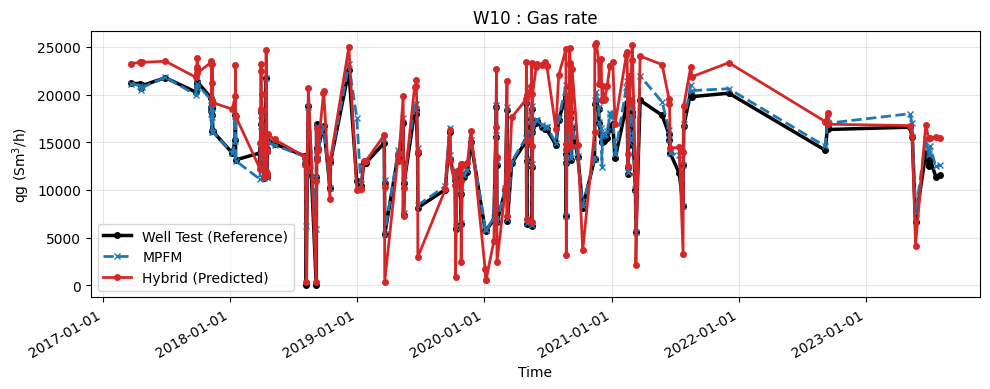

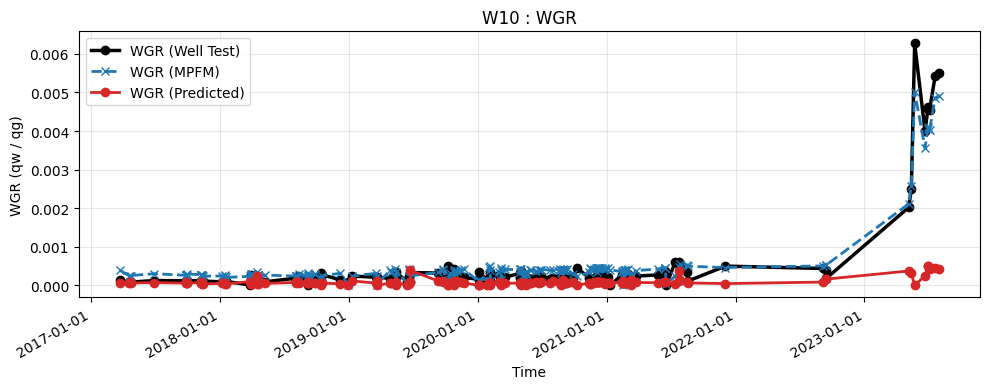

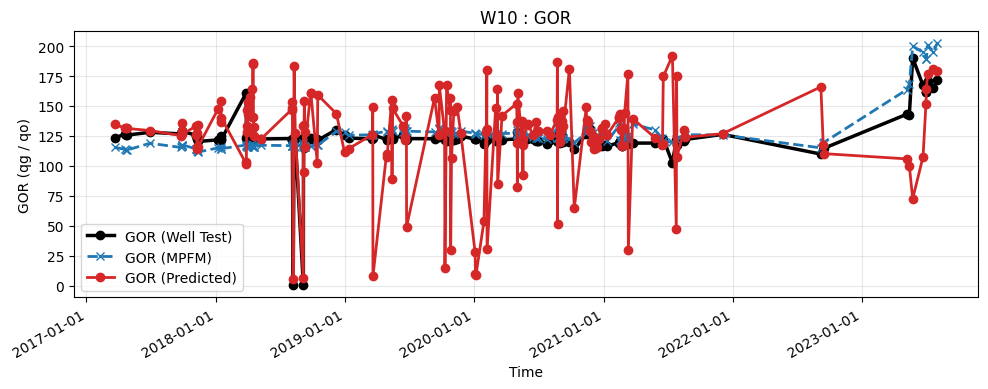

In [340]:
model_lowo.plot_predictions(df=df_test_lowo, model_tag_prefix="lowo")

### Resample and interpolate

In [341]:
# resampler = Resampler()
# df_resampled = resampler.resample_wells(df=df_all_wells_preprocessed, independent_vars=independent_vars)
# print(summarize_null(df=df_resampled))
# print(df_resampled.shape)

In [342]:
# df_resampled.index

In [343]:
# df_resampled.columns

In [344]:
# df_resampled[df_resampled["is_observed"] == 1].shape

In [345]:
# Monotonic
# df_resampled.groupby("well_id")["time_idx"].is_monotonic_increasing

In [346]:
# df_generated = model.generate_dense_well_rates(df=df_resampled)
# df_generated

In [347]:
# summarize_null(df_generated)